# Training an SNN with fewer synops
Similar as in the previous tutorial, we start by defining a spiking model. 

In [1]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl

class SNN(nn.Sequential):
    def __init__(self, batch_size):
        super().__init__(
            sl.FlattenTime(),
            nn.Conv2d(1, 16, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(16, 32, 5, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.SumPool2d(2),
            nn.Conv2d(32, 120, 4, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            nn.Flatten(),
            nn.Linear(120, 10, bias=False),
            sl.IAFSqueeze(batch_size=batch_size),
            sl.UnflattenTime(batch_size=batch_size),
        )

batch_size = 5
snn = SNN(batch_size=batch_size)
snn

SNN(
  (0): FlattenTime(start_dim=0, end_dim=1)
  (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (2): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (3): SumPool2d(norm_type=1, kernel_size=2, stride=None, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (5): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (6): SumPool2d(norm_type=1, kernel_size=2, stride=None, ceil_mode=False)
  (7): Conv2d(32, 120, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (8): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=120, out_features=10, bias=False)
  (11): IAFSqueeze(spike_threshold=1.0, batch_size=5, num_timesteps=-1)
  (12): UnflattenTime()
)

The `SNNAnalyzer` class tracks different statistics for spiking (such as IAF/LIF) and parameter (such as Conv2d/Linear) layers. The number of synaptic operations is part of the parameter layers. If we attach such an analyser to the model, we'll be able to use layer- or model-wide statistics during training, for optimization or logging purposes.

In [2]:
analyser = sinabs.SNNAnalyzer(snn)
print(f"Synops before feeding input: {analyser.get_model_statistics()['synops']}")

rand_input_spikes = (torch.ones((batch_size, 10, 1, 28, 28)) ).float()
y_hat = snn(rand_input_spikes)
print(f"Synops after feeding input: {analyser.get_model_statistics()['synops']}")

Synops before feeding input: 0.0
Synops after feeding input: 37335420.0


You can break down the statistics for each layer:

In [3]:
analyser.get_layer_statistics()

{'1': {'input': tensor(7840.),
  'fanout_prev': 400.0,
  'synops': tensor(3136000.),
  'num_timesteps': 10,
  'time_window': 10.0,
  'SynOps/s': tensor(3.1360e+08)},
 '2': {'firing_rate': tensor(0.2438, grad_fn=<MeanBackward0>),
  'firing_rate_per_neuron': tensor([[[0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
           [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
           [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
           ...,
           [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
           [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
           [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000]],
  
          [[0.9000, 0.9000, 0.9000,  ..., 0.9000, 0.9000, 0.9000],
           [0.9000, 0.9000, 0.9000,  ..., 0.9000, 0.9000, 0.9000],
           [0.9000, 0.9000, 0.9000,  ..., 0.9000, 0.9000, 0.9000],
           ...,
           [0.9000, 0.9000, 0.9000,  ..., 0.9000, 0.9000, 0.9000],
           [0.9000, 0.9000, 0.9000,  ..

Once we have can calculate the total synops, we might want to choose a target synops number in order to decrease power consumption. As a rule of thumb we're going to take half of the number of synops during normal training as constant target. To figure this out, do a training run without synops loss first and observe the numbers. The initial number of synops without having trained the network is not representative enough. We're going to encourage the network to use a fixed number of synaptic operations for a constant input. For demo purposes, we set this to twice the number of operations of the untrained network. We log the number of synops over time and also the average firing rate in the network, which is closely related.

In [4]:
# Find out the target number of operations
target_synops = 2 * analyser.get_model_statistics()['synops'].detach_()

optim = torch.optim.Adam(snn.parameters(), lr=1e-3)

n_synops = []
firing_rates = []
for epoch in range(100):
    sinabs.reset_states(snn)
    sinabs.zero_grad(snn)
    optim.zero_grad()
    
    snn(rand_input_spikes)

    model_stats = analyser.get_model_statistics()
    synops = model_stats['synops']
    firing_rate = model_stats['firing_rate']
    n_synops.append(synops.detach().cpu().numpy())
    firing_rates.append(firing_rate.detach().cpu().numpy())
    
    synops_loss = (target_synops - synops).square() / target_synops.square()
    synops_loss.backward()
    optim.step()


Text(0.5, 0, 'Epoch')

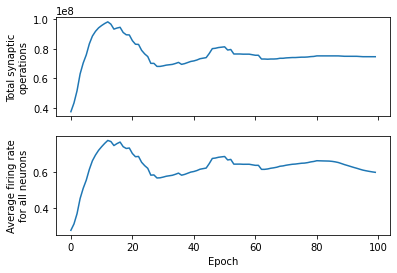

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(n_synops)
ax1.set_ylabel("Total synaptic\noperations")

ax2.plot(firing_rates)
ax2.set_ylabel("Average firing rate\nacross all neurons")

ax2.set_xlabel("Epoch")